# Applied Network Science extension

### Import libraries

In [89]:
import skfda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Own methods

In [97]:
def extract_window(time_window):
    data_aligned=pd.DataFrame()
    for col in data.columns:
        first_inv_year=data.loc[~data[col].isna(), col].index[0]
        if first_inv_year>1999 and first_inv_year<2021-time_window:
            x=data.loc[first_inv_year:,col].reset_index()
            data_aligned[col]=x[col]
    data_aligned=data_aligned.fillna(0)
    data_aligned=data_aligned.cumsum()
    data_export=data_aligned.loc[0:time_window-1,:]
    return data_export

# We run K-means 100 times per sector in order to "be sure" of clustering partitions
def functional_clustering(data):
    clusters={}
    kmeans=skfda.ml.clustering.KMeans(n_clusters=2, n_init=100)
    for sector in content.industry.unique():
        idx=content[content.industry==sector].index_x
        mat=data.loc[:,data.columns.isin(idx)]
        if mat.shape[1]>1:
            fdmat = skfda.FDataGrid(mat.transpose().to_numpy())
            labels=kmeans.fit_predict(fdmat)
            if kmeans.cluster_centers_.evaluate(0.5)[1]>kmeans.cluster_centers_.evaluate(0.5)[0]:
                for x in zip(mat.columns, labels):
                    clusters[x[0]]=x[1]
            else:
                for x in zip(mat.columns, labels):
                    clusters[x[0]]= 0 if x[1]==1 else 1
    return clusters

### Data preprocessing

In [3]:
cb1 = pd.read_csv('cb1.csv')
cb2 = pd.read_csv('cb2.csv')
cb3 = pd.read_csv('cb3.csv')
cb = cb1.append(cb2)
cb = cb.append(cb3)
cb.index = range(len(cb))
cb['date_my'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('m')
cb['date_y'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('y')

nodes_org = cb[['target_name', 'target_ID']].drop_duplicates()
nodes_org['bipartite'] = 1
nodes_inv = cb[['investors_name', 'investor_id']].drop_duplicates()
nodes_org = nodes_org.rename(columns={"target_name": "node", "target_country": "country", 
                                      "target_continent": "continent", "industry":"industry",
                                     "target_ID":"index"})
nodes_inv = nodes_inv.rename(columns={"investors_name": "node","investor_country": "country", 
                                      "investor_continent": "continent", "investor_type":"industry","investor_id":'index' })
nodes_inv['bipartite'] = 0
nodes = nodes_org.append(nodes_inv, ignore_index= True)
nodes['id'] = nodes.index

numbers = cb.groupby(['target_name','stage'], as_index = False).count()[['target_name','stage','investors_name']].rename(columns={"investors_name": "investor_numbers"})
cb_new = pd.merge(cb, numbers,  how='left', left_on=['target_name','stage'], right_on = ['target_name','stage'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 1],  how='left', left_on=['target_name','target_ID'], right_on = ['node','index'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 0],  how='left', left_on=['investors_name','investor_id'], right_on = ['node','index'])

data=cb_new[['target_name', 'industry', 'index_x', 'date_y', 'size_real', 'target_founded', 'target_status', 'round_simp']]
data.date_y=data.date_y.dt.year
a=data.groupby(['round_simp']).count()
a['target_name']=a.target_name/data.shape[0]
remove=['Asset Sale', 'Bridge', 'Dead', 'Debt', 'Distressed & Special Situation', 'Leveraged Buyout', 'Line of Credit', 
 'Loan', 'Management Buyout', 'Milestone Payment', 'Other Investors', 'Portfolio Merger', 'Portfolio NewCo',
 'Secondary Market', 'Shareholder Liquidity']

data=data[data.size_real>0]
data=data[~data.target_founded.isna()]
data=data[data.date_y<2021]
data=data.loc[data.industry.isna()==False,]
data=data.loc[~data.round_simp.isin(remove)]

content=data[['industry','index_x', 'target_name', 'target_founded', 'target_status']].drop_duplicates()
content['alive']=np.where(content.target_status.isin(['Alive / Active']),1,0)

data=data.groupby(['index_x','target_name','date_y']).mean().reset_index()
data=data.pivot('date_y','index_x','size_real')

 /users/testa/.local/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Processing

In [4]:
data10=extract_window(10)

In [96]:
data10

,29.0,64.0,65.0,85.0,102.0,109.0,116.0,184.0,206.0,219.0,...,551271.0,551309.0,551605.0,551800.0,552007.0,559679.0,576878.0,580146.0,632716.0,660680.0
0,2.133636e+07,3.297188e+07,2.619628e+05,1.715246e+07,4.855286e+06,1.125003e+07,4.770676e+07,7.419990e+06,1.349089e+07,5.074074e+06,...,1.372313e+06,1.266930e+08,62772.050401,2.315493e+06,1.934602e+06,9.965976e+06,94073.077807,1.319827e+05,5.087145e+06,1.454473e+08
1,2.133636e+07,3.297188e+07,6.372779e+05,8.390408e+07,2.217543e+07,2.121909e+07,4.770676e+07,7.419990e+06,1.349089e+07,5.074074e+06,...,4.747353e+06,1.266930e+08,62772.050401,5.366718e+06,1.934602e+06,9.965976e+06,94073.077807,1.079009e+06,5.087145e+06,1.454473e+08
2,3.899474e+07,3.297188e+07,1.933739e+06,8.390408e+07,2.217543e+07,2.121909e+07,4.770676e+07,3.498412e+07,4.095466e+07,5.074074e+06,...,4.747353e+06,1.266930e+08,62772.050401,5.366718e+06,1.934602e+06,9.965976e+06,94073.077807,1.079009e+06,5.087145e+06,1.454473e+08
3,3.899474e+07,8.312734e+07,2.816119e+06,8.390408e+07,6.205683e+07,2.121909e+07,1.363433e+08,3.498412e+07,4.095466e+07,5.074074e+06,...,7.318287e+06,1.266930e+08,62772.050401,5.366718e+06,1.934602e+06,9.965976e+06,94073.077807,1.079009e+06,5.087145e+06,1.454473e+08
4,6.316233e+07,1.430096e+08,5.913046e+06,8.390408e+07,6.205683e+07,2.121909e+07,1.363433e+08,3.498412e+07,7.249256e+07,5.074074e+06,...,7.318287e+06,1.266930e+08,62772.050401,5.366718e+06,1.934602e+06,9.965976e+06,94073.077807,1.079009e+06,5.087145e+06,1.454473e+08
5,7.502303e+07,1.430096e+08,8.318222e+06,8.390408e+07,7.173881e+07,2.121909e+07,1.838970e+08,1.054915e+08,7.249256e+07,7.722831e+06,...,1.043733e+07,1.266930e+08,62772.050401,5.366718e+06,1.934602e+06,9.965976e+06,94073.077807,1.079009e+06,5.087145e+06,1.454473e+08
6,7.502303e+07,1.430096e+08,1.186137e+07,8.390408e+07,7.173881e+07,2.121909e+07,2.453320e+08,1.054915e+08,7.249256e+07,7.722831e+06,...,1.043733e+07,1.266930e+08,62772.050401,5.366718e+06,1.934602e+06,9.965976e+06,94073.077807,1.079009e+06,5.087145e+06,1.454473e+08
7,7.502303e+07,1.430096e+08,3.020389e+07,8.390408e+07,7.173881e+07,2.121909e+07,2.453320e+08,1.621123e+08,7.249256e+07,7.722831e+06,...,1.043733e+07,1.266930e+08,62772.050401,5.366718e+06,1.934602e+06,9.965976e+06,94073.077807,1.346851e+06,5.087145e+06,1.454473e+08
8,7.502303e+07,1.646186e+08,4.404822e+07,8.390408e+07,7.173881e+07,2.121909e+07,2.453320e+08,3.077936e+08,7.249256e+07,7.722831e+06,...,1.043733e+07,1.266930e+08,62772.050401,5.366718e+06,1.934602e+06,9.965976e+06,94073.077807,1.346851e+06,5.087145e+06,1.454473e+08
9,7.502303e+07,1.646186e+08,4.878044e+07,8.390408e+07,7.173881e+07,2.121909e+07,2.453320e+08,3.077936e+08,7.249256e+07,7.722831e+06,...,1.043733e+07,1.266930e+08,62772.050401,5.366718e+06,1.934602e+06,9.965976e+06,94073.077807,2.820165e+06,5.087145e+06,1.454473e+08


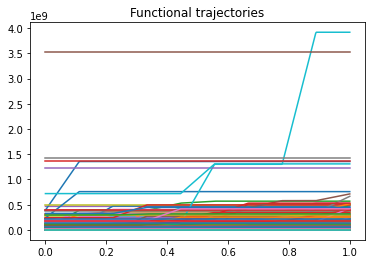

In [86]:
fd = skfda.FDataGrid(data10.transpose().to_numpy())
fd.plot()
plt.title('Functional trajectories')
plt.show()

Logistic regression

In [83]:
clusters=functional_clustering(data10)

Linear regression

In [87]:
cumulate=fd.evaluate(1)

Function-on-scalar regression is not supported. We have to save our functional object matrix and rely on R "refund" package